In [21]:
import pandas as pd
import seaborn as sns
import numpy as np
import pymc3 as pm
import arviz as az
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

%matplotlib inline

This is the first fully worked example of baysian statistics in python using mcmc.  It demonstrates the power of the approach.  Here is the problem statement:

We want to study the effect of the day of the week on the amount of tips at a restaurant. For this example, the different groups are the days. Notice there is no control group or treatment group. If we wish, we can arbitrarily establish one day, for example, Thursday, as the reference or control.

In [3]:
tips = pd.read_csv('./data/tips.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


/Users/m102417/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


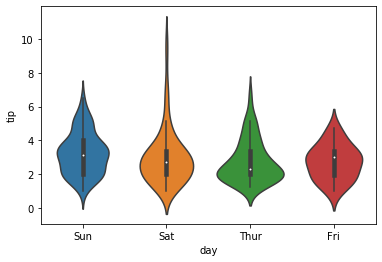

In [6]:
sns.violinplot(x='day', y='tip', data=tips)

From this DataFrame, we are only going to use the day and tip columns.  Just to simplify things, we are going to create three variables: the y variable, representing the tips, the idx variable, a categorical dummy variable to encode the days with numbers, that is, [0, 1, 2, 3] instead of [Thursday, Friday, Saturday, Sunday], and finally the groups variable, with the number of groups (4):

In [17]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))
print(tip)
print(idx)
print(groups)

[ 1.01  1.66  3.5   3.31  3.61  4.71  2.    3.12  1.96  3.23  1.71  5.
  1.57  3.    3.02  3.92  1.67  3.71  3.5   3.35  4.08  2.75  2.23  7.58
  3.18  2.34  2.    2.    4.3   3.    1.45  2.5   3.    2.45  3.27  3.6
  2.    3.07  2.31  5.    2.24  2.54  3.06  1.32  5.6   3.    5.    6.
  2.05  3.    2.5   2.6   5.2   1.56  4.34  3.51  3.    1.5   1.76  6.73
  3.21  2.    1.98  3.76  2.64  3.15  2.47  1.    2.01  2.09  1.97  3.
  3.14  5.    2.2   1.25  3.08  4.    3.    2.71  3.    3.4   1.83  5.
  2.03  5.17  2.    4.    5.85  3.    3.    3.5   1.    4.3   3.25  4.73
  4.    1.5   3.    1.5   2.5   3.    2.5   3.48  4.08  1.64  4.06  4.29
  3.76  4.    3.    1.    4.    2.55  4.    3.5   5.07  1.5   1.8   2.92
  2.31  1.68  2.5   2.    2.52  4.2   1.48  2.    2.    2.18  1.5   2.83
  1.5   2.    3.25  1.25  2.    2.    2.    2.75  3.5   6.7   5.    5.
  2.3   1.5   1.36  1.63  1.73  2.    2.5   2.    2.74  2.    2.    5.14
  5.    3.75  2.61  2.    3.5   2.5   2.    2.    3.    3.48  

mu and sigma are vectors instead of scalar variables.  This means that for the priors, we pass a shape argument and for the likelihood, we properly index the means and sds variables using the idx variable:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:11<00:00, 1987.35draws/s]
/Users/m102417/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c27683470>,
      dtype=object)

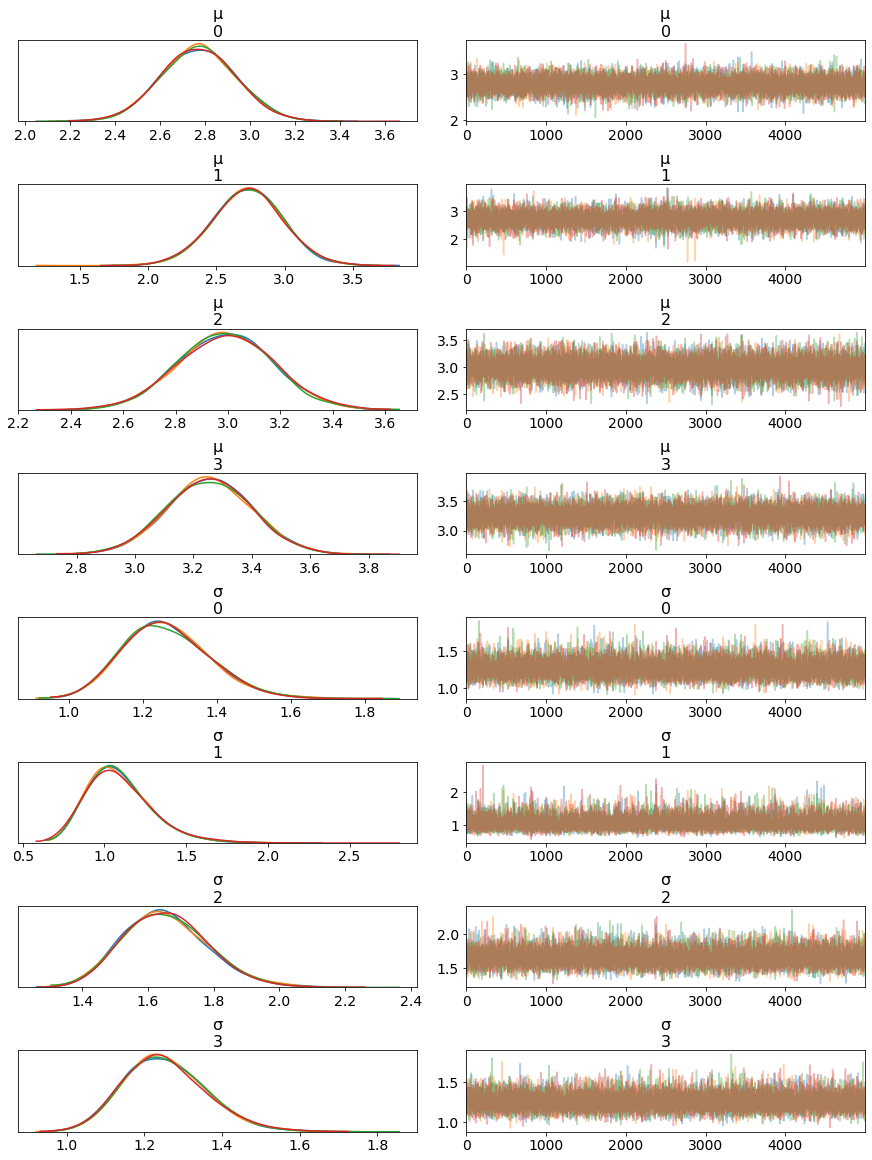

In [15]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    trace_cg = pm.sample(5000)
az.plot_trace(trace_cg)

The following code is just a way of plotting the difference without repeating the comparison. Instead of plotting the all-against-all matrix, we are just plotting the upper triangular portion:



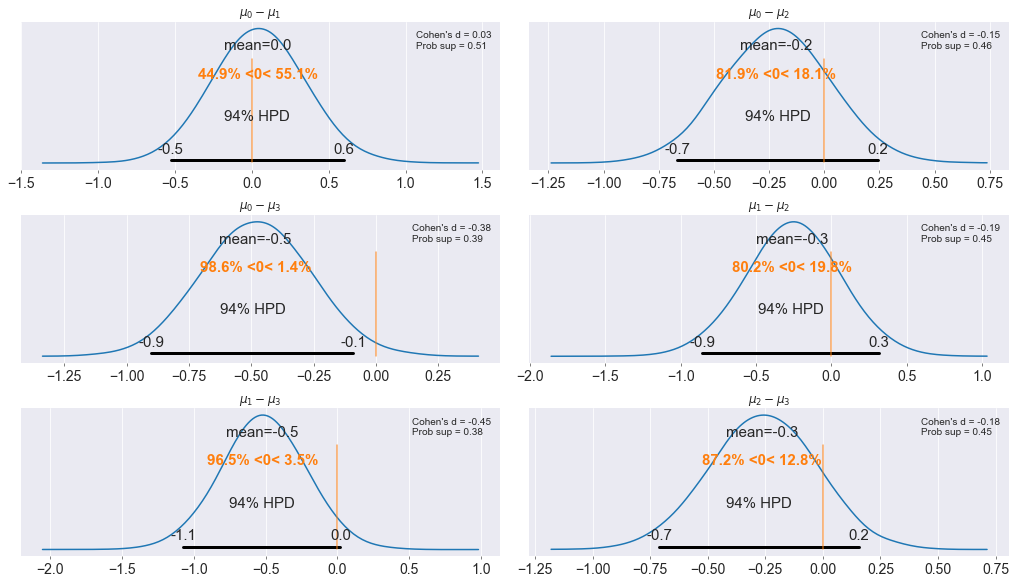

In [22]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()